<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/eywalker/LVIV-2021/blob/main/notebooks/DeepLearing%20in%20Neuroscience.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Welcome to Deep Learning in Neuroscience by Edgar Y. Walker

This is a Jupyter notebook to accompany the course on "Deep Learning in Neuroscience" taught as part of the Lviv Data Science Summer School 2021. This notebook as well as any other relevant information can be found in the [GitHub repository](https://github.com/eywalker/lviv-2021)!

In this course, we will learn how deep learning is getting utilized in studying neuroscience, specifically in building models of neuronal responses to complex sensory inputs such as natural images. We will start by going through some neuroscience primer in slides. We will then get our hands dirty by taking real neuronal responses recorded from mouse primary visual cortex (V1) as the mouse observes a bunch of natural images and developing models to predict these responses. By the end of this course, you will gain basic familiarity in utilizing deep learning models to predict responses of 1000s of neurons to natural images!

## Preparing the environment

#### <font color='red'>NOTE: Please run this section at the very beginning of the first session!</font>

Before we get to dive in and learn how deep learning is used in neuroscience and get your first neural predictive model trained, we need to install some prerequisite packages and download some neuronal data!

### Getting the code

We are going to primarily use [PyTorch](https://pytorch.org) to build, train and evaluate our deep learning models and I am going to assume some familiarity with PyTorch already.

Also to be able to handle the dataset containing neuronal activities, we are going to make our life easier by using a few existing libraries. I have prepared a library called [Lviv-2021](https://github.com/eywalker/lviv-2021). This library has a dependency on [neuralpredictors](https://github.com/sinzlab/neuralpredictors), which is a collection of PyTorch layers, tools and other utilities that would prove helpful to train networks to predict neuronal responses prepared by [Sinz Lab](https://sinzlab.org/).

Let's go ahead and install this inside the Colab environment (you can skip this if you are running this inside a Docker environment).

In [ ]:
# Install PyTorch dependency
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
    
# Install 
!pip3 install git+https://github.com/eywalker/lviv-2021.git

### Getting the dataset

We are going to use the dataset made available for our recent paper [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code), predicting responses of mouse visual cortex to natural images. 

The dataset can take anywhere from 5-10 min to download, so please be sure to **run the following at the very beginning of the session!** We are going to first spend some time learning the basics of neuroscience and it would be best that you let the download take place during that time!

To download the data, simply execute the following cell, and let it run till completion.

In [ ]:
!git clone https://gin.g-node.org/cajal/Lurz2020.git /content/data

# Slide presentation on primer on computational neuroscience

Come back to complete the rest of the notebook after the slide presentation.

# Developing models of neural population responses to natural images

Now that you have been primed with some background neuroscience knowledge, let's get our hands dirty and try to build our first neural predictive model.

As part of the setup, we have downloaded a 2-photon imaging dataset from mouse primary visual cortex as we present 1000s of natural images (if not done yet, please do so immediately by stepping through the beginning sections of this notebook).

Let's go ahead and import a bunch of standard libraries that'll prove useful in exploring our data.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## Navigating the neuroscience data

As with any data science project, you must start by understanding your data! Let's take some time to navigate the data you downloaded.

In [2]:
ls ./data/static20457-5-9-preproc0/

change.log  config.json  data/  meta/


In [3]:
ls ./data/static20457-5-9-preproc0/data

behavior/  images/  pupil_center/  responses/


In [4]:
ls ./data/static20457-5-9-preproc0/data/responses | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


In [5]:
ls ./data/static20457-5-9-preproc0/data/images | head -30

0.npy
1.npy
10.npy
100.npy
1000.npy
1001.npy
1002.npy
1003.npy
1004.npy
1005.npy
1006.npy
1007.npy
1008.npy
1009.npy
101.npy
1010.npy
1011.npy
1012.npy
1013.npy
1014.npy
1015.npy
1016.npy
1017.npy
1018.npy
1019.npy
102.npy
1020.npy
1021.npy
1022.npy
1023.npy
ls: write error: Broken pipe


You can see that both responses and images are contained in collections of `numpy` files named like `1.npy` or `31.npy`. The number here corresponds to a specific **trial** or simply different image presentation during an experiment.

Let's take a look at some of these files.

### Loading data files one at a time

Let's pick some trial and load the image as well as the response

In [7]:
trial_idx = 1100
trial_image = np.load(f'./data/static20457-5-9-preproc0/data/images/{trial_idx}.npy')
trial_responses = np.load(f'./data/static20457-5-9-preproc0/data/responses/{trial_idx}.npy')

The image is shaped as $\text{channel} \times \text{height} \times \text{width}$

In [8]:
trial_image.shape

(1, 36, 64)

(-0.5, 63.5, 35.5, -0.5)

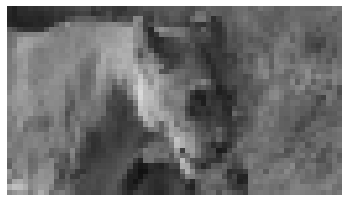

In [9]:
plt.imshow(trial_image.squeeze(), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

In contrast, the shape of `trial_response` is simply the number of neurons

In [12]:
trial_responses.shape

(5335,)

In [13]:
trial_responses.min() # responses are practically always >= 0

-5.409307320414307e-10

In [14]:
trial_responses.max()

53.39189366955226

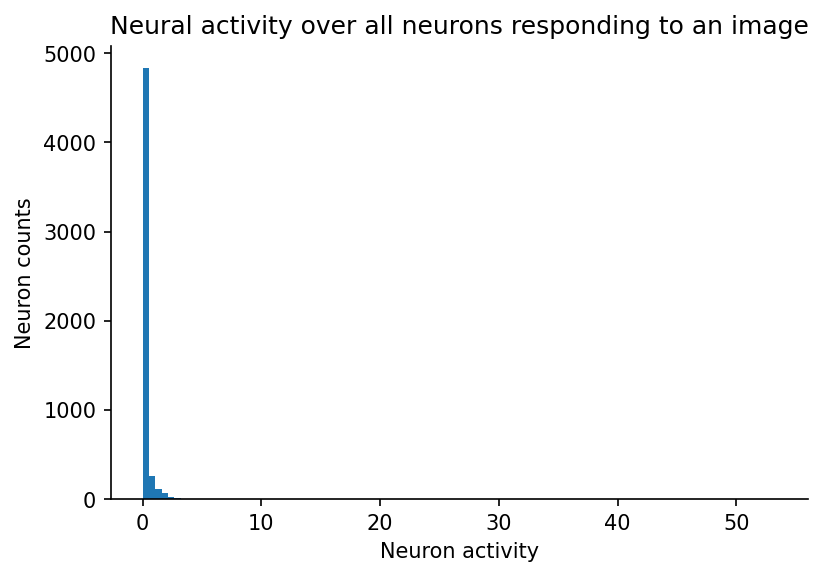

In [41]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.hist(trial_responses, 100);
ax.set_title('Neural activity over all neurons responding to an image')
ax.set_xlabel('Neuron activity')
ax.set_ylabel('Neuron counts')
sns.despine()

You can see most neuron's responses stay very close to 0 - signifying no activity.

### Loading the entire dataset

While we can inspect the image and the corresponding neural population responses one image at a time, this is quite cumbersome and also impractical for use in network training. Fortunately, the `lviv` package provides us with a convenience function that will help to load the entire dataset as PyTorch dataloaders.

In [2]:
from lviv.dataset import load_dataset

As we prepare the dataloaders, we get to specify the batch size.

In [3]:
dataloaders = load_dataset(path = './data/static20457-5-9-preproc0', batch_size=60)

The function returns a dictionary consisting of three dataloaders for training, validation, and test set.

In [20]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1100aeee80>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f1100879400>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1100879310>}

Let's specifically look at the trainset dataloader

In [21]:
train_loader = dataloaders['train']

Total number of images can be checked as follows:

In [22]:
len(train_loader.sampler)

4472

We can inspect what it returns per batch:

In [23]:
images, responses = next(iter(train_loader))

In [24]:
images.shape

torch.Size([60, 1, 36, 64])

In [25]:
responses.shape

torch.Size([60, 5335])

As expected, you can see it returns a batch size of 60 images and responses for all neurons.

Similar inspection can be done on the **validation** and **testing** dataloaders.

In [26]:
# number of images in validation set
len(dataloaders['validation'].sampler)

522

In [27]:
# number of images in test set
len(dataloaders['test'].sampler)

999

You might think that we have a lot of images in test set, but this is because test set consists of repeated images.

Some additional trial information can be observed by accessing the underlying PyTorch dataset object and looking at the `trial_info`. Note that this is not part of the standard PyTorch dataset/dataloader interface, but rather a feature specifically provided by our `lviv` library!

In [14]:
# Access to the dataset object that underlies all dataloaders
dataset = dataloaders['test'].dataset

In [30]:
# get trials that are marked as "test" set
test_trials = np.where(dataset.trial_info.tiers == 'test')[0]

In [229]:
# get information about the presented image for ALL trials
image_ids = dataset.trial_info.frame_image_id

In [230]:
# find IDs of all unique images presented during test trials
unique_test_images = np.unique(image_ids[test_trials])
unique_test_images

array([ 104,  128,  183,  355,  479,  483,  656,  803,  830,  936, 1201,
       1494, 1596, 1652, 1656, 1682, 1731, 1756, 1796, 2005, 2008, 2014,
       2159, 2214, 2389, 2586, 2710, 2746, 2747, 2803, 2816, 2825, 2954,
       3018, 3107, 3144, 3163, 3372, 3427, 3438, 3487, 3507, 3562, 3702,
       3847, 3924, 4231, 4295, 4373, 4397, 4400, 4430, 4594, 4619, 4667,
       4674, 4717, 4739, 4782, 4812, 4814, 4821, 4923, 4953, 5034, 5128,
       5166, 5225, 5264, 5288, 5322, 5334, 5399, 5402, 5504, 5640, 5671,
       5679, 5754, 5782, 6013, 6034, 6066, 6082, 6205, 6238, 6248, 6490,
       6562, 6773, 6790, 6831, 6886, 7017, 7028, 7107, 7119, 7120, 7154,
       7495])

In [231]:
len(unique_test_images)

100

We can see that the test set consists of 100 unique images, each repeated up to 10 times.

Let's now take a look at how a neuron responds to these repeated presentations of an identical image.

In [261]:
from tqdm import tqdm
# gather the responses to the repeated image presentations
repeated_image_responses = []
for unique_test_image_id in tqdm(unique_test_images):
    repeated_image_trials = test_trials[image_ids[test_trials] == unique_test_image_id]
    responses = np.stack([dataset[trial][1].cpu().numpy() for trial in repeated_image_trials])
    repeated_image_responses.append((unique_test_image_id, responses))

100%|██████████| 100/100 [00:00<00:00, 456.96it/s]


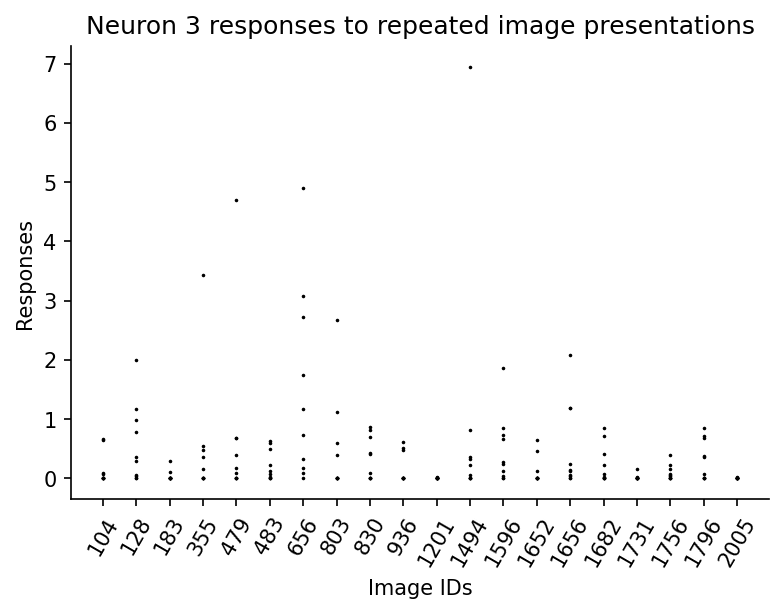

In [264]:
neuron_idx = 3 # choose one neuron to inspect its responses

fig, ax = plt.subplots(1, 1, dpi=150)
labels = []
for i, (image_id, responses) in enumerate(repeated_image_responses[:20]):
    ax.scatter(np.ones(len(responses)) * i, responses[:, neuron_idx], c='k', s=0.5)
    labels.append(image_id)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=60)
ax.set_title(f'Neuron {neuron_idx} responses to repeated image presentations')
ax.set_xlabel('Image IDs')
ax.set_ylabel('Responses')
sns.despine()

You can see that indeed a single neuorn's responses vary widely even to repeated presentations of an identical stimulus! This **noiseness** of neural responses make predicting the respones of the neurons to images fundamentally challenging and also esssentially make it impossible to yield perfect fit! Instead, we would often try to fit the **distribution of responses** the best we can, and we will briefly visit this point later.

# Modeling the neuronal responses

Now that we have successfully loaded the dataset and inspected its contents, it's time for us to start **modeling** the responses.

We will start by building a very basic **Linear-Nonlinear model** - which is nothing more than a shallow neural network with single linear layer followed by an activation function.

## Linear-Nonlinear (LN) model

### Background

Arguably one of the simplest model of a neuron's response to a stimulus is the **linear-nonlinear (LN) model**. 

Given an image $I \in \mathbb{R}^{h\,\times\,w}$ where $h$ and $w$ are the height and the width of the image, respectively, let us collapse the image into a vector $x \in \mathbb{R}^{hw}$.

A single neuron's response $r$ under linear-nonlinear model can then be expressed as:
$$
r = a(\mathbf{w}^\top x + b),
$$
where $\mathbf{w} \in \mathbb{R}^{hw}$ and $b \in \mathbb{R}$ are **weight** and **bias**, and $a:\mathbb{R}\mapsto\mathbb{R}$ is a scalar **activating function**.

We can in fact extend to capture the responses of all $N$ neurons simultaneously as:

$$
\mathbf{r} = a(\mathbf{W} x + \mathbf{b}),
$$
where $\mathbf{r} \in \mathbb{R}^{N}$, $\mathbf{W} \in \mathbb{R}^{N\,\times\,hw}$ and $\mathbf{b} \in \mathbb{R}^{N}$.

Hence, each neuron weighs each pixel of the image according to the weight $\mathbf{w}$ (corresopnds to a row of $\mathbf{W}$) and thus characterizes how much the each neuron "cares" about a specific pixel.

The weight $\mathbf{w}$ can be thought of as a **filter** that's the same size as the image and is overlaid on top of the image to determine what pixel would contribute to the neuron's response. 

This *image filter* is typically referred to as the **receptive field** of the neuron!

The nonlinear activation function $a(\cdot)$ ensures, among other things, that the output of the network stays above 0. In fitting neuronal responses, we tend to use $a(x) = ELU(x) + 1$ where ELU (Exponential Linear Unit) is defined as follows:

$$
    ELU(x) = 
\begin{cases}
    e^x - 1, & x \lt 0 \\
    x,   & x \ge 0
\end{cases}
$$

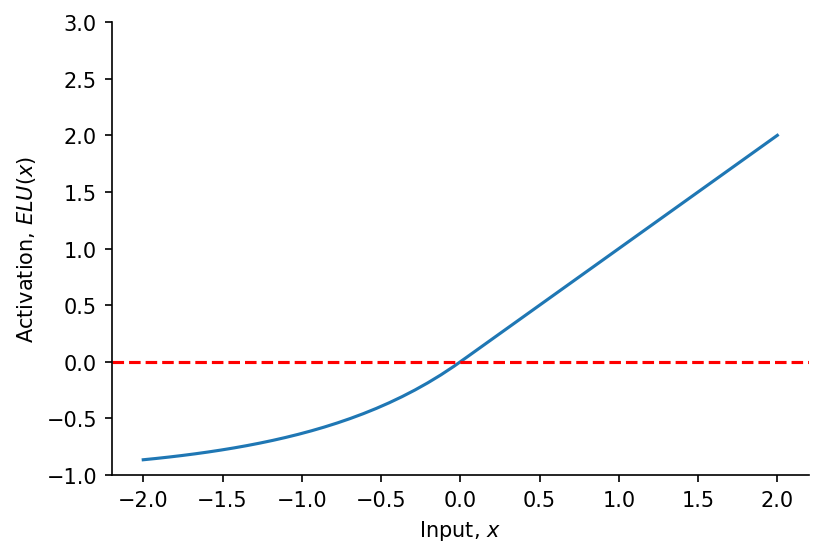

In [49]:
# Plotting ELU function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x)))
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x)$')
ax.set_ylim([-1, 3])
sns.despine()

We shift it by 1 to ensure it will always remain positive

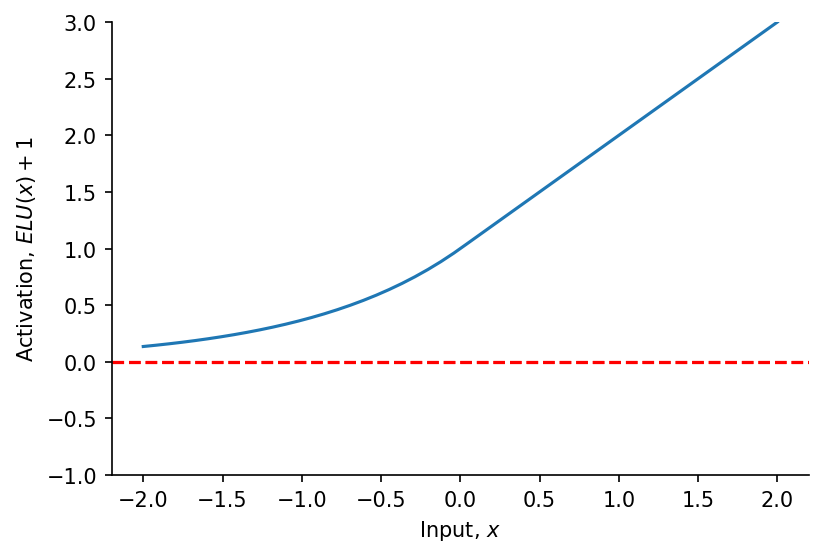

In [50]:
# Plotting ELU+1 function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x))+1)
ax.axhline(0, c='r', ls='--')
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x) + 1$')
ax.set_ylim([-1, 3.0])
sns.despine()

Overall, it can be seen that a linear-nonlinear (LN) model is nothing more than a single linear layer applied on a flattened image input, followed by a nonlinear activation function (i.e. $ELU(x)+1$). 

Now let's go ahead and implment our LN model in PyTorch!

### Implementation

We implement a simple network consisting of a linear layer followed by ELU + 1 activation

In [78]:
class Linear(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.0,
    ):
        super().__init__()
        self.bn = nn.BatchNorm2d(1, momentum=momentum, affine=False)
        self.linear = nn.Linear(input_height * input_width, n_neurons)
        self.gamma = gamma
        self.init_std = init_std
        self.initialize()
        
    
    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x.flatten(1))
        return nn.functional.elu(x) + 1
        

    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        nn.init.normal_(self.linear.weight.data, std=std)


    def regularizer(self):
        return self.gamma * self.linear.weight.abs().sum()


And that's it! We have now designed our first network model of the neuron's responses!

**BONUS**: notice that we used batch normalization (BN) layer right before the linear layer? This empirically helps to stabilize the training, allowing us to be not too sensitive to the weight and bias initialization. You could totally implement and train a LN network without such BN layer and you are more than welcome to try! However if you do, be very aware of the network weight initializations and the chocie of learning rate during the training.

Finally, let's instantiate the model before we move onto the next step of training the model!

In [79]:
ln_model = Linear(input_height=64, input_width=36, n_neurons=5335, gamma=0.1)

### Training the network

Now that we have a candidate model designed, it's time to train it. While we could use standard set of optimizers as provided by PyTorch to implement our training routine, here we are provided with a convenience function `train_model` that would handle a lot of the training boiler plate.

In [6]:
from lviv.trainers import train_model

Critically, `train_model` sets up the training based on **Poisson loss** and also perform early stopping based on **correlation** of the predicted neuronal responses with the actual neuronal responses on the **validation set**. Let's now talk briefly about our objective (loss) function of choice in training neuron response models - the Poisson loss.

### Mathematical aside: Poisson Loss

#### How we are **actually** modeling the noisy neuronal responses

The use of **Poisson loss** follows from the assumption that, *conditioned on the stimulus*, the neurons' responses follow an **independent Poisson** distribution. That is, given an input image $x$, the population response $\mathbf{r}$ is distributed as:

$$
p(\mathbf{r} | x) = \prod_i^N \text{Poiss}(r_i; \lambda_i(x))
$$

where $r_i$ is the $i^\text{th}$ neuron in the population $\mathbf{r}$. The $\lambda_i$ is the parameter for Poisson distribution that controls its **average value**. Here we express $\lambda_i(x)$ to indicate the fact that the average response for each neuron is expected to vary *as a function of the input image*. We can express this average matching as:

$$
\mathbb{E}[r_i|x] = \lambda_i(x)
$$

In fact, it is precisely this function $\lambda_i(x)$ that we are modeling using LN models and, in the next step, more complex neural networks. In otherwords, we are learning $\lambda_i(x) = f_i(x, \theta)$, where $\theta$ is the trainable parameters of the model.

Putting all together, this means that, our model $f(x, \theta)$ is really modeling the average activity of the neurons,

$$
\mathbb{E}[\mathbf{r}|x] = \mathbf{f}(x, \theta)
$$

while we are assuming that the neurons are distributed according to **independent Poisson** distribution around the average responses predicted by our model $\mathbf{f}(x, \theta)$.

#### Deriving the objective function

Poisson distribution is defined as follows:

$$
p(r) = \text{Poiss}(r; \lambda) = \frac{e^{-\lambda}\lambda^{r}}{r!}
$$

During the training, we would want to adjust the model parameter $\theta$ to maximize the chance of observing the response $\mathbf{r}$ to a known image $x$. This is achieved by **maximizing** the log-likelihood function $\log p(\mathbf{r}|x, \theta)$, or equivalently by **minimzing the negative log-likelihood function** as the objective function $L(x, \mathbf{r}, \theta)$:

$$
\begin{align}
L(x, \mathbf{r}, \theta) &= -\log p(\mathbf{r}|x, \theta) \\
&= -\log \prod_i \text{Poiss}(r_i; f_i(x, \theta)) \\
&= -\sum_i \log \frac{e^{-f_i(x, \theta)}f_i(x, \theta)^{r_i}}{r_i!} \\
&= \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta) + \log r_i! \right)
\end{align}
$$


During the optimization, we seek for $\theta$ that would minimize the loss $L$. Note that since the term $\log r_i!$ does not depend on $\theta$, it can be safely dropped from Poisson loss. Hence you would commonly see the following expression as the definition of the **Poisson loss**

$$
L_\text{Poiss}(x, \mathbf{r}, \theta) = \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta)\right)
$$

### Performing the training

Now that we have the theoretical foundation for the training and the choice of the objective function under our belt, let's go ahead and train the network. Because the function `train_model` handles a lot underneath the hood, training a model is just as easy as invoking the function by passing it the model to be trained and the dataloaders!

In [5]:
from lviv.trainers import train_model

In [82]:
score, output, model_state = train_model(model=ln_model, dataloader=dataloaders)

correlation -0.0028376007
poisson_loss 9536425.0


Epoch 1: 100%|██████████| 75/75 [00:04<00:00, 15.25it/s]


[001|00/05] ---> 0.06291262805461884
correlation 0.06291263
poisson_loss 3233414.0


Epoch 2: 100%|██████████| 75/75 [00:00<00:00, 82.23it/s]


[002|00/05] ---> 0.07530715316534042
correlation 0.07530715
poisson_loss 2823158.8


Epoch 3: 100%|██████████| 75/75 [00:00<00:00, 84.48it/s]


[003|00/05] ---> 0.08148764073848724
correlation 0.08148764
poisson_loss 2646291.5


Epoch 4: 100%|██████████| 75/75 [00:00<00:00, 79.08it/s]


[004|01/05] -/-> 0.07675723731517792
correlation 0.07675724
poisson_loss 2614737.5


Epoch 5: 100%|██████████| 75/75 [00:00<00:00, 84.55it/s]


[005|01/05] ---> 0.0831238180398941
correlation 0.08312382
poisson_loss 2618676.0


Epoch 6: 100%|██████████| 75/75 [00:00<00:00, 84.46it/s]


[006|00/05] ---> 0.08651387691497803
correlation 0.08651388
poisson_loss 2535143.0


Epoch 7: 100%|██████████| 75/75 [00:00<00:00, 84.79it/s]


[007|00/05] ---> 0.08859601616859436
correlation 0.088596016
poisson_loss 2492160.0


Epoch 8: 100%|██████████| 75/75 [00:00<00:00, 82.08it/s]


[008|00/05] ---> 0.0907663106918335
correlation 0.09076631
poisson_loss 2553214.2


Epoch 9: 100%|██████████| 75/75 [00:01<00:00, 74.58it/s]


[009|01/05] -/-> 0.08925200253725052
correlation 0.089252
poisson_loss 2550302.2


Epoch 10: 100%|██████████| 75/75 [00:00<00:00, 83.80it/s]


[010|02/05] -/-> 0.08571925759315491
correlation 0.08571926
poisson_loss 2573360.5


Epoch 11: 100%|██████████| 75/75 [00:00<00:00, 80.87it/s]


[011|03/05] -/-> 0.08661939948797226
correlation 0.0866194
poisson_loss 2674216.0


Epoch 12: 100%|██████████| 75/75 [00:00<00:00, 78.25it/s]


[012|04/05] -/-> 0.08475182950496674
correlation 0.08475183
poisson_loss 2640827.0


Epoch 13: 100%|██████████| 75/75 [00:00<00:00, 84.00it/s]


[013|05/05] -/-> 0.08563712239265442
Restoring best model after lr decay! 0.085637 ---> 0.090766
correlation 0.09076631
poisson_loss 2553214.2


Epoch 14: 100%|██████████| 75/75 [00:00<00:00, 83.38it/s]


Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.08135292679071426
correlation 0.08135293
poisson_loss 2619570.5


Epoch 15: 100%|██████████| 75/75 [00:00<00:00, 78.23it/s]


[015|01/05] ---> 0.1087164357304573
correlation 0.108716436
poisson_loss 2224880.0


Epoch 16: 100%|██████████| 75/75 [00:00<00:00, 83.09it/s]


[016|01/05] -/-> 0.10778597742319107
correlation 0.10778598
poisson_loss 2203862.2


Epoch 17: 100%|██████████| 75/75 [00:00<00:00, 81.61it/s]


[017|02/05] -/-> 0.10817896574735641
correlation 0.108178966
poisson_loss 2206134.0


Epoch 18: 100%|██████████| 75/75 [00:00<00:00, 79.73it/s]


[018|03/05] -/-> 0.10457243025302887
correlation 0.10457243
poisson_loss 2235500.5


Epoch 19: 100%|██████████| 75/75 [00:00<00:00, 83.66it/s]


[019|04/05] -/-> 0.10566174983978271
correlation 0.10566175
poisson_loss 2214932.5


Epoch 20: 100%|██████████| 75/75 [00:00<00:00, 76.61it/s]


[020|05/05] -/-> 0.10366460680961609
Restoring best model after lr decay! 0.103665 ---> 0.108716
correlation 0.108716436
poisson_loss 2224880.0


Epoch 21: 100%|██████████| 75/75 [00:00<00:00, 84.06it/s]


Epoch    21: reducing learning rate of group 0 to 4.5000e-04.
[021|01/05] -/-> 0.10407443344593048
correlation 0.10407443
poisson_loss 2212213.8


Epoch 22: 100%|██████████| 75/75 [00:00<00:00, 83.28it/s]


[022|01/05] ---> 0.1141660287976265
correlation 0.11416603
poisson_loss 2135080.5


Epoch 23: 100%|██████████| 75/75 [00:00<00:00, 79.38it/s]


[023|00/05] ---> 0.1154339537024498
correlation 0.11543395
poisson_loss 2140812.5


Epoch 24: 100%|██████████| 75/75 [00:00<00:00, 83.30it/s]


[024|01/05] -/-> 0.11267277598381042
correlation 0.112672776
poisson_loss 2145623.5


Epoch 25: 100%|██████████| 75/75 [00:00<00:00, 84.19it/s]


[025|02/05] -/-> 0.11420059949159622
correlation 0.1142006
poisson_loss 2142161.2


Epoch 26: 100%|██████████| 75/75 [00:00<00:00, 84.52it/s]


[026|03/05] -/-> 0.11442482471466064
correlation 0.114424825
poisson_loss 2131446.8


Epoch 27: 100%|██████████| 75/75 [00:00<00:00, 83.87it/s]


[027|04/05] -/-> 0.11402616649866104
correlation 0.11402617
poisson_loss 2143431.0


Epoch 28: 100%|██████████| 75/75 [00:00<00:00, 83.13it/s]


[028|05/05] -/-> 0.11184372752904892
Restoring best model after lr decay! 0.111844 ---> 0.115434
Restoring best model! 0.115434 ---> 0.115434


### Analyzing the trained network

Woohoo! We have now successfully trained our very first LN model on real neuronal responses! But really, how good is the model?

During the training, the `train_model` function iteratively reported two values: the loss function (Poisson loss) value and the average correlation. 

But what is this correlation? It's simply the correlation computed between our predicted neuronal responses $\hat{r}_i$ and the actual neuronal responses $r_i$ across images in the validation set. We then take the average correlation value **across neurons** to get average correlation.

Being a correlation, the highest possible value is of course 1.0. Practically speaking, this is never reached both due to 1) imperfection of our model and more fundamentally due to 2) the noiseness of the neuron's responses. Because of the noise, even a perfect model would never reach a correlation of 1.0.

Let's actually go ahead and look at the model's predicted responses on the test set and compare them against the actual responses. The package `lviv` provides for a convenient function to quickly gather the model's responses and the actual responses.

In [173]:
from lviv.utility import measures
from scipy.stats import pearsonr

actual_responses, model_responses = measures.model_predictions(ln_model, dataloaders['test'], device='cuda')

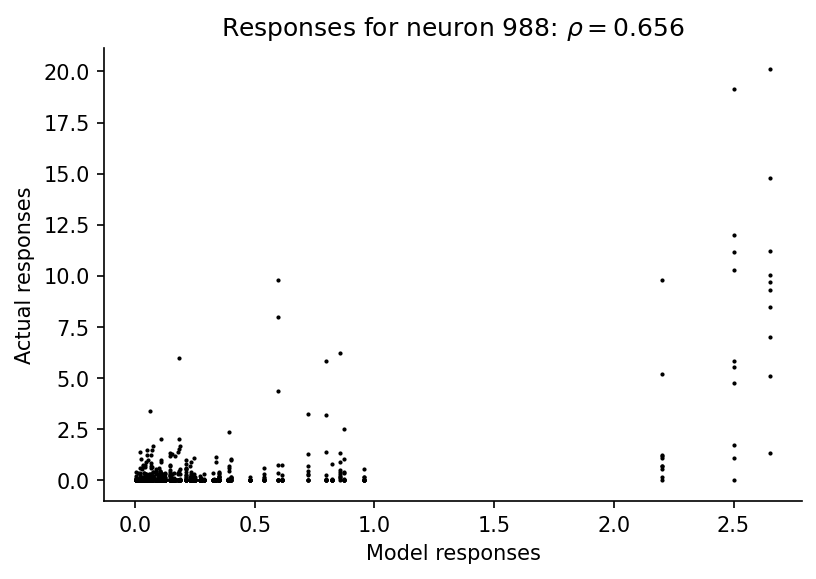

In [176]:
# pick a neuron to generate the plot for
neuron_idx = 988

# compute Pearson correlation
r, _ = pearsonr(model_responses[:, neuron_idx], actual_responses[:, neuron_idx])
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(model_responses[:, neuron_idx], actual_responses[:, neuron_idx], c='k', s=1.0)
ax.set_title(f'Responses for neuron {neuron_idx}: $\\rho = {r:.3f}$')
ax.set_xlabel('Model responses')
ax.set_ylabel('Actual responses')
sns.despine()

Let's take a look at how this correlation is distributed across neurons. This time, we'll use `get_gorrelations` function to compute correation for all neurons quickly.

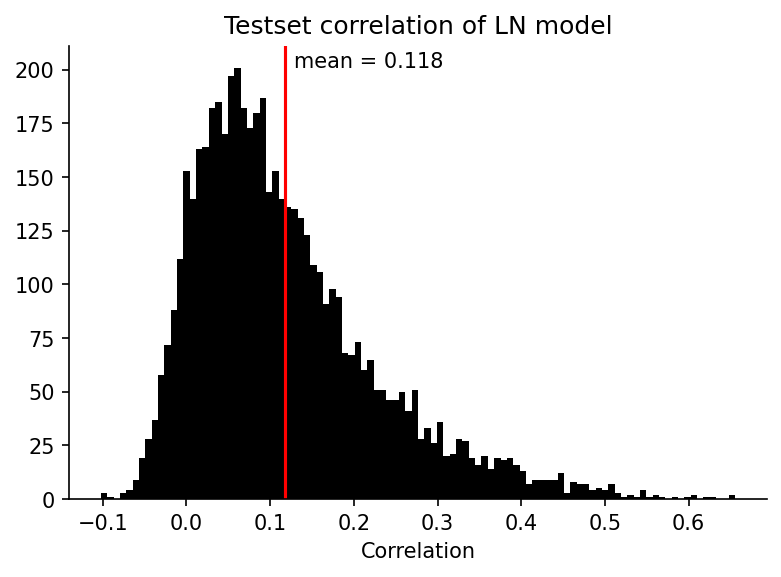

In [186]:
# compute correlation on test set
ln_test_correlations = measures.get_correlations(
    ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(ln_test_correlations, bins=100, color='k')
ax.axvline(np.mean(ln_test_correlations), color="r")
ax.text(
    x=np.mean(ln_test_correlations) + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(np.mean(ln_test_correlations)),
)
ax.set_title('Testset correlation of LN model')
ax.set_xlabel('Correlation')
sns.despine()

You can see that value of achieved correlation on the test set widely varies among the neurons. Some neurons are quite well predicted, reaching correlation above 0.6, where as many neurons have correlation well below 0.1.

## Going beyond Linear-Nonlinear model by using CNN

We saw that a simple LN model can be trained to achieve above chance performance in predicting the responses of mouse V1 neurons to natural images. But we certainly must be able to do better than that, right?

In the past decase, what has really driven system identification of visual neurons has been the use of convolutional neural networks (CNN). Below, we will try out a very simple CNN to see if we can already reach better performance than LN.

In [179]:
from collections import OrderedDict
class CNN(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.1,
        hidden_channels=8,
    ):
        super(CNN, self).__init__()
        self.init_std = init_std
        self.gamma = gamma

        # CNN core
        self.cnn_core = nn.Sequential(
            OrderedDict(
                [
                    ("conv1", nn.Conv2d(1, hidden_channels, 15, padding=15 // 2, bias=False)),
                    ("bn1", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu1", nn.ELU()),
                    ("conv2", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn2", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu2", nn.ELU()),
                    ("conv3", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn3", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu3", nn.ELU()),
                    ("conv4", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn4", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu4", nn.ELU()),
                ]
            )
        )

        # Fully connected readout
        self.readout = nn.Sequential(
            OrderedDict(
                [
                    ('fc_ro', nn.Linear(input_height * input_width * hidden_channels, n_neurons)),
                    ('bn_ro', nn.BatchNorm1d(n_neurons, momentum=momentum)),
                ]
            )
        )


    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, std=std)

    def forward(self, x):
        x = self.cnn_core(x)
        x = x.view(x.size(0), -1)
        x = self.readout(x)
        return nn.functional.elu(x) + 1
    
    def regularizer(self):
        return self.readout[0].weight.abs().sum() * self.gamma


Let us now instantiate the model and train it!

In [88]:
cnn_model = CNN(input_height=64, input_width=36, n_neurons=5335)
score, output, model_state = train_model(model=cnn_model, dataloader=dataloaders)

correlation -0.00045015095
poisson_loss 4177012.8


Epoch 1: 100%|██████████| 75/75 [00:04<00:00, 15.26it/s]


[001|00/05] ---> 0.053945496678352356
correlation 0.053945497
poisson_loss 2966264.5


Epoch 2: 100%|██████████| 75/75 [00:04<00:00, 15.51it/s]


[002|00/05] ---> 0.10886244475841522
correlation 0.108862445
poisson_loss 2061814.6


Epoch 3: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[003|00/05] ---> 0.14153477549552917
correlation 0.14153478
poisson_loss 1919906.2


Epoch 4: 100%|██████████| 75/75 [00:04<00:00, 15.29it/s]


[004|00/05] ---> 0.1499428153038025
correlation 0.14994282
poisson_loss 1901764.0


Epoch 5: 100%|██████████| 75/75 [00:04<00:00, 15.34it/s]


[005|00/05] ---> 0.16296586394309998
correlation 0.16296586
poisson_loss 1864801.8


Epoch 6: 100%|██████████| 75/75 [00:04<00:00, 15.50it/s]


[006|00/05] ---> 0.18991662561893463
correlation 0.18991663
poisson_loss 1816717.0


Epoch 7: 100%|██████████| 75/75 [00:04<00:00, 15.33it/s]


[007|00/05] ---> 0.19636401534080505
correlation 0.19636402
poisson_loss 1824522.8


Epoch 8: 100%|██████████| 75/75 [00:04<00:00, 15.37it/s]


[008|00/05] ---> 0.20466706156730652
correlation 0.20466706
poisson_loss 1804877.4


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 15.37it/s]


[009|00/05] ---> 0.20793630182743073
correlation 0.2079363
poisson_loss 1799221.1


Epoch 10: 100%|██████████| 75/75 [00:04<00:00, 15.38it/s]


[010|01/05] -/-> 0.20705397427082062
correlation 0.20705397
poisson_loss 1806472.5


Epoch 11: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[011|02/05] -/-> 0.2040378600358963
correlation 0.20403786
poisson_loss 1846206.5


Epoch 12: 100%|██████████| 75/75 [00:04<00:00, 15.48it/s]


[012|03/05] -/-> 0.1922161877155304
correlation 0.19221619
poisson_loss 1884127.5


Epoch 13: 100%|██████████| 75/75 [00:04<00:00, 15.21it/s]


[013|04/05] -/-> 0.18458996713161469
correlation 0.18458997
poisson_loss 1897588.4


Epoch 14: 100%|██████████| 75/75 [00:04<00:00, 15.51it/s]


[014|05/05] -/-> 0.17324768006801605
Restoring best model after lr decay! 0.173248 ---> 0.207936
correlation 0.2079363
poisson_loss 1799221.1


Epoch 15: 100%|██████████| 75/75 [00:04<00:00, 15.49it/s]


Epoch    15: reducing learning rate of group 0 to 1.5000e-03.
[015|01/05] -/-> 0.20133435726165771
correlation 0.20133436
poisson_loss 1817016.5


Epoch 16: 100%|██████████| 75/75 [00:04<00:00, 15.39it/s]


[016|02/05] -/-> 0.20695102214813232
correlation 0.20695102
poisson_loss 1803929.9


Epoch 17: 100%|██████████| 75/75 [00:04<00:00, 15.60it/s]


[017|03/05] -/-> 0.20145919919013977
correlation 0.2014592
poisson_loss 1822813.8


Epoch 18: 100%|██████████| 75/75 [00:04<00:00, 15.49it/s]


[018|04/05] -/-> 0.1929115504026413
correlation 0.19291155
poisson_loss 1847443.2


Epoch 19: 100%|██████████| 75/75 [00:04<00:00, 15.57it/s]


[019|05/05] -/-> 0.18579795956611633
Restoring best model after lr decay! 0.185798 ---> 0.207936
correlation 0.2079363
poisson_loss 1799221.1


Epoch 20: 100%|██████████| 75/75 [00:04<00:00, 15.60it/s]


[020|00/05] ---> 0.21430984139442444
correlation 0.21430984
poisson_loss 1789777.2


Epoch 21: 100%|██████████| 75/75 [00:04<00:00, 15.55it/s]


[021|01/05] -/-> 0.20966924726963043
correlation 0.20966925
poisson_loss 1800760.5


Epoch 22: 100%|██████████| 75/75 [00:04<00:00, 15.41it/s]


[022|02/05] -/-> 0.20322349667549133
correlation 0.2032235
poisson_loss 1815298.0


Epoch 23: 100%|██████████| 75/75 [00:04<00:00, 15.57it/s]


[023|03/05] -/-> 0.19595438241958618
correlation 0.19595438
poisson_loss 1833899.8


Epoch 24: 100%|██████████| 75/75 [00:04<00:00, 15.35it/s]


[024|04/05] -/-> 0.1888420134782791
correlation 0.18884201
poisson_loss 1869610.0


Epoch 25: 100%|██████████| 75/75 [00:04<00:00, 15.31it/s]


[025|05/05] -/-> 0.18056949973106384
Restoring best model after lr decay! 0.180569 ---> 0.214310
Restoring best model! 0.214310 ---> 0.214310


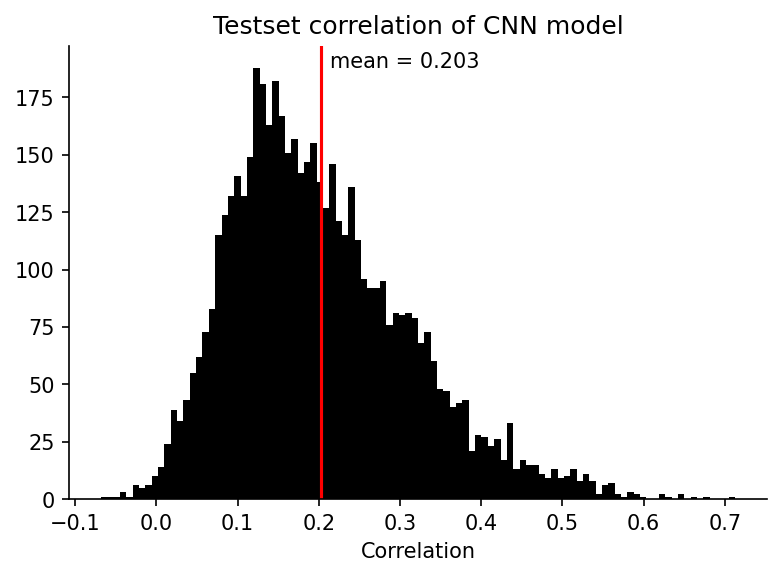

In [184]:
# compute correlation on test set
cnn_test_correlations = measures.get_correlations(
    cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of CNN model')
ax.set_xlabel('Correlation')
sns.despine()

So on average, it seems to do better than our simple LN model. Let's compare the performance for each neuron between the two models.

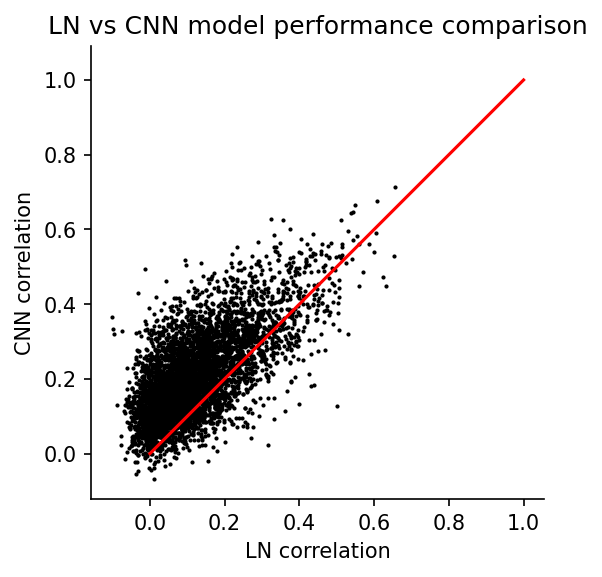

In [188]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(ln_test_correlations, cnn_test_correlations, color="k", s=1)
ax.set_xlabel('LN correlation')
ax.set_ylabel('CNN correlation')
ax.set_title('LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

You can appreciate that for vast majority of neurons (each black point), the CNN model yields better predictive performance than the LN model.

## Trying out the State-of-the-Art (SOTA) model

Now that we got some sense on how we could go about training linear and nonlinear network models to predict V1 neuron responses to natural images, and we just saw how using a CNN model brings significant improvement to the performance beyond the LN model.

You might now be wondering, how good can we get? To get a sense of this, let's go ahead and train a state-of-the-art (SOTA) CNN model for mouse V1 responses to natual images as published in our recent work in [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code).

To keep things simple, I have provided for the network implementation in the `lviv` package, so you can build the model just by invoking a function!

In [21]:
from lviv.models import build_lurz2020_model
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439
               }

sota_cnn_model = build_lurz2020_model(**model_config, dataloaders=dataloaders, seed=1234)

In [22]:
score, output, model_state = train_model(model=sota_cnn_model, dataloader=dataloaders)

correlation 0.00034036028
poisson_loss 3467926.2


Epoch 1: 100%|██████████| 75/75 [00:03<00:00, 24.90it/s]


[001|00/05] ---> 0.0680275559425354
correlation 0.068027556
poisson_loss 1933858.6


Epoch 2: 100%|██████████| 75/75 [00:02<00:00, 25.01it/s]


[002|00/05] ---> 0.09929622709751129
correlation 0.09929623
poisson_loss 1907483.5


Epoch 3: 100%|██████████| 75/75 [00:02<00:00, 25.01it/s]


[003|00/05] ---> 0.13518217206001282
correlation 0.13518217
poisson_loss 1867110.0


Epoch 4: 100%|██████████| 75/75 [00:03<00:00, 25.00it/s]


[004|00/05] ---> 0.1598946452140808
correlation 0.15989465
poisson_loss 1841945.0


Epoch 5: 100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


[005|00/05] ---> 0.18218474090099335
correlation 0.18218474
poisson_loss 1817149.9


Epoch 6: 100%|██████████| 75/75 [00:02<00:00, 25.03it/s]


[006|00/05] ---> 0.20660726726055145
correlation 0.20660727
poisson_loss 1790352.0


Epoch 7: 100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


[007|00/05] ---> 0.22382909059524536
correlation 0.22382909
poisson_loss 1772525.0


Epoch 8: 100%|██████████| 75/75 [00:03<00:00, 24.91it/s]


[008|00/05] ---> 0.22999538481235504
correlation 0.22999538
poisson_loss 1773642.2


Epoch 9: 100%|██████████| 75/75 [00:03<00:00, 24.82it/s]


[009|00/05] ---> 0.24508711695671082
correlation 0.24508712
poisson_loss 1747728.8


Epoch 10: 100%|██████████| 75/75 [00:03<00:00, 24.83it/s]


[010|00/05] ---> 0.25037065148353577
correlation 0.25037065
poisson_loss 1738160.4


Epoch 11: 100%|██████████| 75/75 [00:03<00:00, 24.83it/s]


[011|00/05] ---> 0.2633332312107086
correlation 0.26333323
poisson_loss 1725654.0


Epoch 12: 100%|██████████| 75/75 [00:03<00:00, 24.82it/s]


[012|01/05] -/-> 0.2629813849925995
correlation 0.26298138
poisson_loss 1730108.0


Epoch 13: 100%|██████████| 75/75 [00:03<00:00, 24.81it/s]


[013|01/05] ---> 0.2683899700641632
correlation 0.26838997
poisson_loss 1716678.5


Epoch 14: 100%|██████████| 75/75 [00:03<00:00, 24.79it/s]


[014|00/05] ---> 0.27141842246055603
correlation 0.27141842
poisson_loss 1719357.9


Epoch 15: 100%|██████████| 75/75 [00:03<00:00, 24.78it/s]


[015|00/05] ---> 0.27544060349464417
correlation 0.2754406
poisson_loss 1706908.8


Epoch 16: 100%|██████████| 75/75 [00:03<00:00, 24.76it/s]


[016|00/05] ---> 0.2799447178840637
correlation 0.27994472
poisson_loss 1706215.8


Epoch 17: 100%|██████████| 75/75 [00:03<00:00, 24.86it/s]


[017|01/05] -/-> 0.2778717875480652
correlation 0.2778718
poisson_loss 1704406.2


Epoch 18: 100%|██████████| 75/75 [00:03<00:00, 24.89it/s]


[018|01/05] ---> 0.28171613812446594
correlation 0.28171614
poisson_loss 1699294.4


Epoch 19: 100%|██████████| 75/75 [00:03<00:00, 24.76it/s]


[019|00/05] ---> 0.28334832191467285
correlation 0.28334832
poisson_loss 1700168.6


Epoch 20: 100%|██████████| 75/75 [00:03<00:00, 24.73it/s]


[020|01/05] -/-> 0.28233516216278076
correlation 0.28233516
poisson_loss 1703476.0


Epoch 21: 100%|██████████| 75/75 [00:03<00:00, 24.78it/s]


[021|01/05] ---> 0.28639575839042664
correlation 0.28639576
poisson_loss 1695269.2


Epoch 22: 100%|██████████| 75/75 [00:03<00:00, 24.80it/s]


[022|01/05] -/-> 0.2859424650669098
correlation 0.28594247
poisson_loss 1698494.0


Epoch 23: 100%|██████████| 75/75 [00:03<00:00, 24.76it/s]


[023|01/05] ---> 0.2886219620704651
correlation 0.28862196
poisson_loss 1692460.9


Epoch 24: 100%|██████████| 75/75 [00:03<00:00, 24.67it/s]


[024|01/05] -/-> 0.28071242570877075
correlation 0.28071243
poisson_loss 1711751.9


Epoch 25: 100%|██████████| 75/75 [00:03<00:00, 24.67it/s]


[025|02/05] -/-> 0.28673169016838074
correlation 0.2867317
poisson_loss 1700509.0


Epoch 26: 100%|██████████| 75/75 [00:03<00:00, 24.77it/s]


[026|02/05] ---> 0.28893551230430603
correlation 0.2889355
poisson_loss 1693557.0


Epoch 27: 100%|██████████| 75/75 [00:03<00:00, 24.64it/s]


[027|01/05] -/-> 0.28601011633872986
correlation 0.28601012
poisson_loss 1698208.0


Epoch 28: 100%|██████████| 75/75 [00:03<00:00, 24.73it/s]


[028|01/05] ---> 0.28958719968795776
correlation 0.2895872
poisson_loss 1692636.0


Epoch 29: 100%|██████████| 75/75 [00:03<00:00, 24.54it/s]


[029|01/05] -/-> 0.28838568925857544
correlation 0.2883857
poisson_loss 1694810.4


Epoch 30: 100%|██████████| 75/75 [00:03<00:00, 24.57it/s]


[030|02/05] -/-> 0.28596487641334534
correlation 0.28596488
poisson_loss 1698947.9


Epoch 31: 100%|██████████| 75/75 [00:03<00:00, 24.46it/s]


[031|03/05] -/-> 0.28742775321006775
correlation 0.28742775
poisson_loss 1699829.5


Epoch 32: 100%|██████████| 75/75 [00:03<00:00, 24.57it/s]


[032|03/05] ---> 0.2918780744075775
correlation 0.29187807
poisson_loss 1687537.6


Epoch 33: 100%|██████████| 75/75 [00:03<00:00, 24.59it/s]


[033|01/05] -/-> 0.2894161641597748
correlation 0.28941616
poisson_loss 1691721.5


Epoch 34: 100%|██████████| 75/75 [00:03<00:00, 24.58it/s]


[034|02/05] -/-> 0.28705477714538574
correlation 0.28705478
poisson_loss 1693822.8


Epoch 35: 100%|██████████| 75/75 [00:03<00:00, 24.61it/s]


[035|03/05] -/-> 0.28763920068740845
correlation 0.2876392
poisson_loss 1697323.0


Epoch 36: 100%|██████████| 75/75 [00:03<00:00, 24.62it/s]


[036|04/05] -/-> 0.29025959968566895
correlation 0.2902596
poisson_loss 1694309.6


Epoch 37: 100%|██████████| 75/75 [00:03<00:00, 24.62it/s]


[037|05/05] -/-> 0.2860703468322754
Restoring best model after lr decay! 0.286070 ---> 0.291878
correlation 0.29187807
poisson_loss 1687537.6


Epoch 38: 100%|██████████| 75/75 [00:03<00:00, 24.57it/s]


Epoch    38: reducing learning rate of group 0 to 1.5000e-03.
[038|01/05] -/-> 0.2864190638065338
correlation 0.28641906
poisson_loss 1699188.4


Epoch 39: 100%|██████████| 75/75 [00:03<00:00, 24.28it/s]


[039|01/05] ---> 0.29661256074905396
correlation 0.29661256
poisson_loss 1677973.2


Epoch 40: 100%|██████████| 75/75 [00:03<00:00, 24.58it/s]


[040|01/05] -/-> 0.2954838275909424
correlation 0.29548383
poisson_loss 1679961.8


Epoch 41: 100%|██████████| 75/75 [00:03<00:00, 24.50it/s]


[041|02/05] -/-> 0.2956898808479309
correlation 0.29568988
poisson_loss 1680874.1


Epoch 42: 100%|██████████| 75/75 [00:03<00:00, 24.51it/s]


[042|03/05] -/-> 0.29176387190818787
correlation 0.29176387
poisson_loss 1694208.0


Epoch 43: 100%|██████████| 75/75 [00:03<00:00, 24.52it/s]


[043|04/05] -/-> 0.29101210832595825
correlation 0.2910121
poisson_loss 1692490.6


Epoch 44: 100%|██████████| 75/75 [00:03<00:00, 24.51it/s]


[044|05/05] -/-> 0.2914881408214569
Restoring best model after lr decay! 0.291488 ---> 0.296613
correlation 0.29661256
poisson_loss 1677973.2


Epoch 45: 100%|██████████| 75/75 [00:03<00:00, 24.53it/s]


Epoch    45: reducing learning rate of group 0 to 4.5000e-04.
[045|01/05] -/-> 0.295950710773468
correlation 0.2959507
poisson_loss 1680209.0


Epoch 46: 100%|██████████| 75/75 [00:03<00:00, 24.53it/s]


[046|01/05] ---> 0.29676511883735657
correlation 0.29676512
poisson_loss 1679979.0


Epoch 47: 100%|██████████| 75/75 [00:03<00:00, 24.51it/s]


[047|01/05] -/-> 0.29602012038230896
correlation 0.29602012
poisson_loss 1682869.2


Epoch 48: 100%|██████████| 75/75 [00:03<00:00, 24.49it/s]


[048|02/05] -/-> 0.29338088631629944
correlation 0.2933809
poisson_loss 1690477.6


Epoch 49: 100%|██████████| 75/75 [00:03<00:00, 24.51it/s]


[049|03/05] -/-> 0.29538264870643616
correlation 0.29538265
poisson_loss 1680648.0


Epoch 50: 100%|██████████| 75/75 [00:03<00:00, 24.49it/s]


[050|04/05] -/-> 0.2931114435195923
correlation 0.29311144
poisson_loss 1687856.5


Epoch 51: 100%|██████████| 75/75 [00:03<00:00, 24.50it/s]


[051|05/05] -/-> 0.29385605454444885
Restoring best model after lr decay! 0.293856 ---> 0.296765
Restoring best model! 0.296765 ---> 0.296765


As usual, let's take a look at the testset performance.

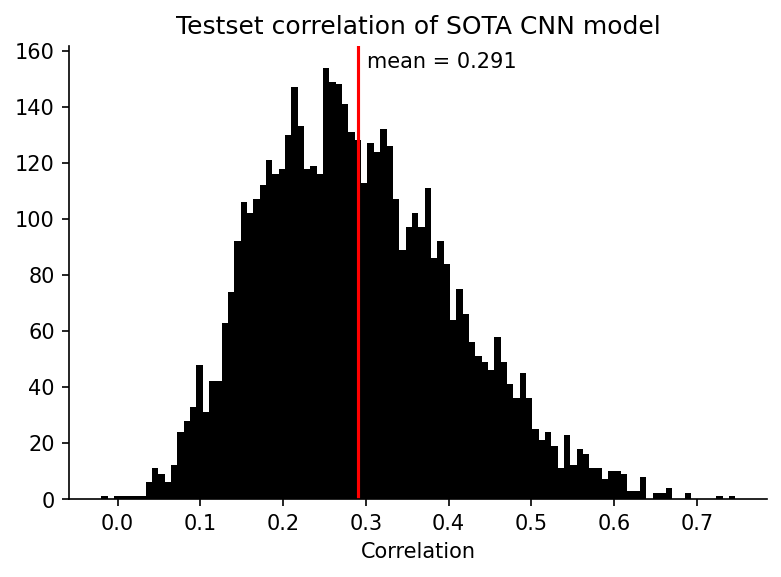

In [194]:
# compute correlation on test set
sota_cnn_test_correlations = measures.get_correlations(
    sota_cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA CNN model')
ax.set_xlabel('Correlation')
sns.despine()

It turns out that we can have *linearized* version of the SOTA model. This effectively removes all nonlinear operations within the network except for the very last nonlinear activation, rendering the network into a **LN model** but with more complex architecture.

In [7]:
linear_model_config = dict(model_config) # copy the config
linear_model_config['linear'] = True # set linear to True to make it a LN model!

sota_ln_model = build_lurz2020_model(**linear_model_config, dataloaders=dataloaders, seed=1234)

In [8]:
score, output, model_state = train_model(model=sota_ln_model, dataloader=dataloaders)

correlation 0.0003725943
poisson_loss 3467901.0


Epoch 1: 100%|██████████| 75/75 [00:05<00:00, 14.08it/s]


[001|00/05] ---> 0.03264817222952843
correlation 0.032648172
poisson_loss 1995768.0


Epoch 2: 100%|██████████| 75/75 [00:02<00:00, 25.52it/s]


[002|00/05] ---> 0.07385799288749695
correlation 0.07385799
poisson_loss 1920868.8


Epoch 3: 100%|██████████| 75/75 [00:02<00:00, 25.61it/s]


[003|00/05] ---> 0.10280311852693558
correlation 0.10280312
poisson_loss 1890175.0


Epoch 4: 100%|██████████| 75/75 [00:02<00:00, 25.53it/s]


[004|00/05] ---> 0.119008369743824
correlation 0.11900837
poisson_loss 1881780.0


Epoch 5: 100%|██████████| 75/75 [00:02<00:00, 25.48it/s]


[005|00/05] ---> 0.13928116858005524
correlation 0.13928117
poisson_loss 1867511.8


Epoch 6: 100%|██████████| 75/75 [00:02<00:00, 25.50it/s]


[006|00/05] ---> 0.155312180519104
correlation 0.15531218
poisson_loss 1849152.9


Epoch 7: 100%|██████████| 75/75 [00:02<00:00, 25.44it/s]


[007|00/05] ---> 0.16527961194515228
correlation 0.16527961
poisson_loss 1843706.0


Epoch 8: 100%|██████████| 75/75 [00:02<00:00, 25.38it/s]


[008|00/05] ---> 0.17541857063770294
correlation 0.17541857
poisson_loss 1828310.5


Epoch 9: 100%|██████████| 75/75 [00:02<00:00, 25.32it/s]


[009|00/05] ---> 0.18246866762638092
correlation 0.18246867
poisson_loss 1821006.2


Epoch 10: 100%|██████████| 75/75 [00:02<00:00, 25.38it/s]


[010|00/05] ---> 0.19085784256458282
correlation 0.19085784
poisson_loss 1813584.0


Epoch 11: 100%|██████████| 75/75 [00:02<00:00, 25.33it/s]


[011|00/05] ---> 0.196898952126503
correlation 0.19689895
poisson_loss 1808833.2


Epoch 12: 100%|██████████| 75/75 [00:02<00:00, 25.27it/s]


[012|00/05] ---> 0.19789183139801025
correlation 0.19789183
poisson_loss 1812027.8


Epoch 13: 100%|██████████| 75/75 [00:02<00:00, 25.22it/s]


[013|00/05] ---> 0.2013990432024002
correlation 0.20139904
poisson_loss 1801582.5


Epoch 14: 100%|██████████| 75/75 [00:02<00:00, 25.26it/s]


[014|01/05] -/-> 0.1987954080104828
correlation 0.19879541
poisson_loss 1811106.0


Epoch 15: 100%|██████████| 75/75 [00:02<00:00, 25.29it/s]


[015|01/05] ---> 0.20188070833683014
correlation 0.20188071
poisson_loss 1802814.2


Epoch 16: 100%|██████████| 75/75 [00:02<00:00, 25.24it/s]


[016|00/05] ---> 0.20617102086544037
correlation 0.20617102
poisson_loss 1800652.8


Epoch 17: 100%|██████████| 75/75 [00:02<00:00, 25.23it/s]


[017|01/05] -/-> 0.2059662789106369
correlation 0.20596628
poisson_loss 1797902.5


Epoch 18: 100%|██████████| 75/75 [00:03<00:00, 24.95it/s]


[018|01/05] ---> 0.20806053280830383
correlation 0.20806053
poisson_loss 1794937.1


Epoch 19: 100%|██████████| 75/75 [00:02<00:00, 25.21it/s]


[019|01/05] -/-> 0.20631732046604156
correlation 0.20631732
poisson_loss 1798377.9


Epoch 20: 100%|██████████| 75/75 [00:02<00:00, 25.12it/s]


[020|02/05] -/-> 0.20738708972930908
correlation 0.20738709
poisson_loss 1795764.0


Epoch 21: 100%|██████████| 75/75 [00:02<00:00, 25.16it/s]


[021|02/05] ---> 0.21108558773994446
correlation 0.21108559
poisson_loss 1793347.9


Epoch 22: 100%|██████████| 75/75 [00:02<00:00, 25.02it/s]


[022|01/05] -/-> 0.20856666564941406
correlation 0.20856667
poisson_loss 1797049.5


Epoch 23: 100%|██████████| 75/75 [00:03<00:00, 24.99it/s]


[023|02/05] -/-> 0.20851819217205048
correlation 0.20851819
poisson_loss 1796151.5


Epoch 24: 100%|██████████| 75/75 [00:02<00:00, 25.04it/s]


[024|03/05] -/-> 0.20422649383544922
correlation 0.2042265
poisson_loss 1799048.5


Epoch 25: 100%|██████████| 75/75 [00:02<00:00, 25.08it/s]


[025|03/05] ---> 0.21223492920398712
correlation 0.21223493
poisson_loss 1790819.4


Epoch 26: 100%|██████████| 75/75 [00:02<00:00, 25.09it/s]


[026|01/05] -/-> 0.2060323804616928
correlation 0.20603238
poisson_loss 1797437.2


Epoch 27: 100%|██████████| 75/75 [00:02<00:00, 25.03it/s]


[027|02/05] -/-> 0.20969833433628082
correlation 0.20969833
poisson_loss 1792595.6


Epoch 28: 100%|██████████| 75/75 [00:02<00:00, 25.03it/s]


[028|03/05] -/-> 0.20987549424171448
correlation 0.2098755
poisson_loss 1792965.8


Epoch 29: 100%|██████████| 75/75 [00:02<00:00, 25.03it/s]


[029|04/05] -/-> 0.2119886577129364
correlation 0.21198866
poisson_loss 1793984.2


Epoch 30: 100%|██████████| 75/75 [00:02<00:00, 25.05it/s]


[030|05/05] -/-> 0.2065286934375763
Restoring best model after lr decay! 0.206529 ---> 0.212235
correlation 0.21223493
poisson_loss 1790819.4


Epoch 31: 100%|██████████| 75/75 [00:02<00:00, 25.05it/s]


Epoch    31: reducing learning rate of group 0 to 1.5000e-03.
[031|01/05] -/-> 0.2080124169588089
correlation 0.20801242
poisson_loss 1799330.2


Epoch 32: 100%|██████████| 75/75 [00:03<00:00, 25.00it/s]


[032|01/05] ---> 0.21621014177799225
correlation 0.21621014
poisson_loss 1784467.4


Epoch 33: 100%|██████████| 75/75 [00:03<00:00, 24.90it/s]


[033|01/05] -/-> 0.21508656442165375
correlation 0.21508656
poisson_loss 1782818.0


Epoch 34: 100%|██████████| 75/75 [00:03<00:00, 24.90it/s]


[034|02/05] -/-> 0.21568970382213593
correlation 0.2156897
poisson_loss 1784149.5


Epoch 35: 100%|██████████| 75/75 [00:03<00:00, 24.87it/s]


[035|03/05] -/-> 0.21554909646511078
correlation 0.2155491
poisson_loss 1782804.8


Epoch 36: 100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


[036|04/05] -/-> 0.2138994038105011
correlation 0.2138994
poisson_loss 1784304.8


Epoch 37: 100%|██████████| 75/75 [00:03<00:00, 24.85it/s]


[037|05/05] -/-> 0.21570609509944916
Restoring best model after lr decay! 0.215706 ---> 0.216210
correlation 0.21621014
poisson_loss 1784467.4


Epoch 38: 100%|██████████| 75/75 [00:03<00:00, 24.90it/s]


Epoch    38: reducing learning rate of group 0 to 4.5000e-04.
[038|01/05] -/-> 0.21482974290847778
correlation 0.21482974
poisson_loss 1784736.0


Epoch 39: 100%|██████████| 75/75 [00:03<00:00, 24.96it/s]


[039|02/05] -/-> 0.21620075404644012
correlation 0.21620075
poisson_loss 1780881.6


Epoch 40: 100%|██████████| 75/75 [00:03<00:00, 24.97it/s]


[040|02/05] ---> 0.21641814708709717
correlation 0.21641815
poisson_loss 1782926.5


Epoch 41: 100%|██████████| 75/75 [00:03<00:00, 24.46it/s]


[041|01/05] -/-> 0.21474385261535645
correlation 0.21474385
poisson_loss 1782494.2


Epoch 42: 100%|██████████| 75/75 [00:03<00:00, 24.81it/s]


[042|02/05] -/-> 0.21550948917865753
correlation 0.21550949
poisson_loss 1781389.0


Epoch 43: 100%|██████████| 75/75 [00:03<00:00, 24.93it/s]


[043|03/05] -/-> 0.21515703201293945
correlation 0.21515703
poisson_loss 1782010.9


Epoch 44: 100%|██████████| 75/75 [00:03<00:00, 24.59it/s]


[044|04/05] -/-> 0.216171532869339
correlation 0.21617153
poisson_loss 1781607.1


Epoch 45: 100%|██████████| 75/75 [00:03<00:00, 24.99it/s]


[045|05/05] -/-> 0.2159837931394577
Restoring best model after lr decay! 0.215984 ---> 0.216418
Restoring best model! 0.216418 ---> 0.216418


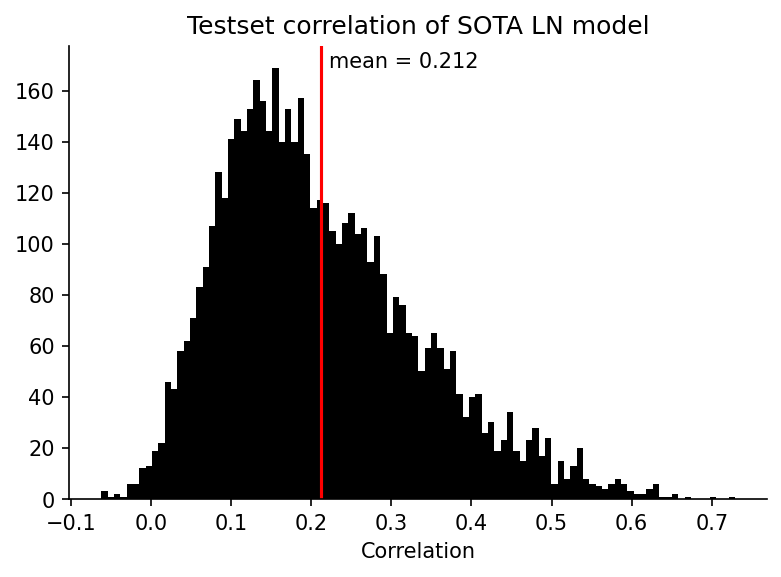

In [198]:
# compute correlation on test set
sota_ln_test_correlations = measures.get_correlations(
    sota_ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_ln_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_ln_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA LN model')
ax.set_xlabel('Correlation')
sns.despine()

Interestingly, you can see that compared to our simple LN model, the SOTA LN model actually attains much better performance. This, among other things, reflects the **ease of training** the CNN based network compared to our *fully-connected* simple linear model. Despite the architectural complexity of the SOTA LN model, it is still a LN model as was described mathematically as:

$$
\mathbf{r} = a(\mathbf{W} x + \mathbf{b})
$$

### Compare model performance between SOTA CNN and SOTA LN model

Just as before, let's compare the performanc of SOTA CNN vs SOTA LN.

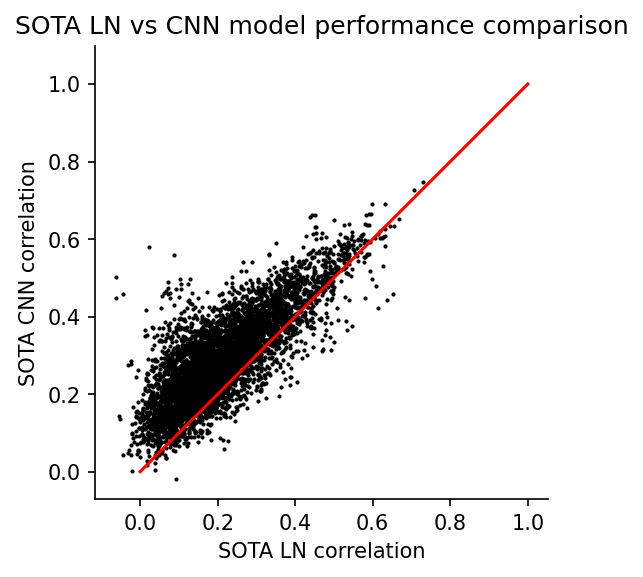

In [200]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(sota_ln_test_correlations, sota_cnn_test_correlations, color="k", s=1)
ax.set_xlabel('SOTA LN correlation')
ax.set_ylabel('SOTA CNN correlation')
ax.set_title('SOTA LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

We can see that SOTA CNN model still performans better than the SOTA LN model across most of the neurons.

# Analyzing the trained models to gain insights into the brain

Now that we have trained some models successfully with decent predictive performances, you might be wondering what can we do with these models?

Ideally, we could use these models to gain insights into the modeled neurons, and even potentially derive new predictions that can then be tested with new set of experiments.

Let's first analyze the **gradient receptive field (RF)** of the modeled neurons to get a rough sense of what is it that each neuron is *looking for* in the image when they respond.

## Gradient Receptive Fields (RF)

Let's consider our simple linear-nonlinear (LN) model. Recall from above that for each neuron, the response of the model to an image $x$ can be captured as follows:

$$
r = a(\mathbf{w}^\top x + b)
$$

and I already mentioned that the $\mathbf{w}$ can be thought of as a image filter that selects out pixels that the neuron cares about. This filter is typically referred to as the **receptive field** of the (LN) neuron.

It can actually be seen that we can **compute** the receptive field $\mathbf{w}$ by simply taking the **gradient of the response with respect to the input image**:

$$
\nabla_x r = a^\prime(\mathbf{w}^\top x + b) \cdot \mathbf{w}
$$

You could see that $a^\prime(\mathbf{w}^\top x + b)$ is still a scalar function that will evalute to some scalar value, and therefore,

$$
\nabla_x r \propto \mathbf{w}
$$

Therefore, you can compute the gradient of the model with respect to the input image to get the receptive field $\mathbf{w}$ up to some scalar constant. This method of obtaining the receptive field is commonly referred to as the **gradient receptive field (RF)**.

Note that for LN model, gradient RF correctly approximates the weight $\mathbf{w}$. However when this is applied to more highly nonlinear models like CNNs, the gradient RF can be thought of as giving a locally linear approximation to the CNN model, and still provide some rough insight into what is it that each neuron is looking for when they respond to an image.

Let's now go ahead and compute the gradient RF for our models. We will make use of the PyTorch automatic differentiation system to easily compute the gradient with respect to the image.

**DETAILS**: For LN model, it actually doesn't matter too much *where* you compute the gradient at (that is, what value of input image $x$ you will feed in). However the where can matter quite a bit more when evaluting grad RF for highly nonlinear models such as our CNN model. For this reason, we are going to feed in an *average image* which will be a gray image with intensity set to the average value across all images in the training set. This value has been precomputed and provided as part of the `dataset` that underlies our data loaders.

Let us define a function that, when given a model, neuron index, and the image at which point you want to evaluate the gradient, returns the gradient RF.

In [15]:
def generate_grad_rf(model, neuron_idx, input_image):
    assert input_image.ndim == 2
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device="cuda",
        requires_grad=True,
    )
    # be sure to put the model on eval mode
    model.eval()
    # get the response of the target neuron
    model_activation = model(x)[:, neuron_idx]
    # compute gradient with respect to the input
    model_activation.backward()
    
    # prepare the gradient RF
    grad_rf = x.grad.data.cpu().numpy().squeeze()
    return grad_rf

In [16]:
# choose input mean as starting point
input_mean = dataset.statistics.images.all.mean
input_std = dataset.statistics.images.all.std

Let's go ahead and genearte and visualize the grad RF for both our SOTA CNN and SOTA LN models.

In [17]:
# select neuron to compute RFs
neuron_idx = 1

Text(0.5, 0.8, 'Gradient receptive fields')

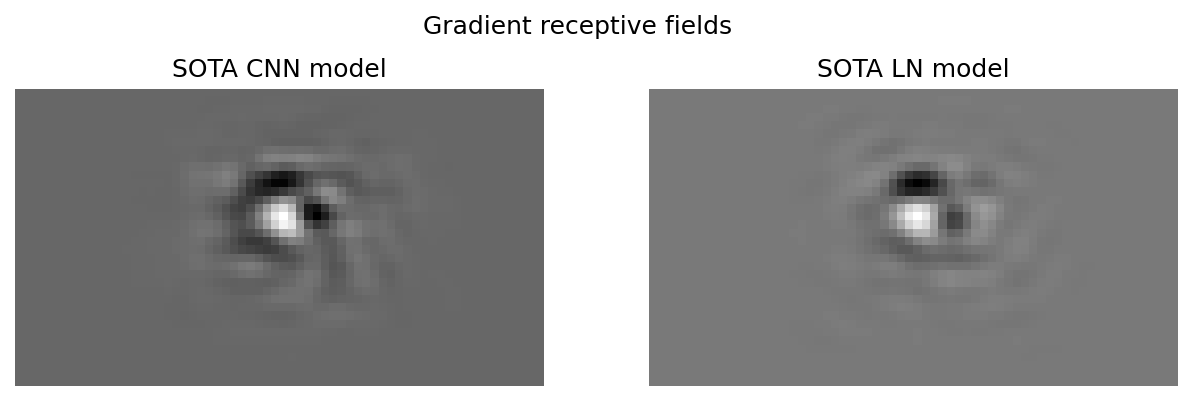

In [18]:
# generate a gradient receptive field from the sota_model and the sota_ln_model
input_image = np.zeros((36, 64)) + input_mean

grad_rf_sota_cnn = generate_grad_rf(
    sota_cnn_model, neuron_idx=neuron_idx, input_image=input_image
)
grad_rf_sota_ln = generate_grad_rf(
    sota_ln_model, neuron_idx=neuron_idx, input_image=input_image
)

# visualize the two gradient RFs side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)

scale = np.max([np.max(np.abs(img)) for img in [grad_rf_sota_cnn, grad_rf_sota_ln]])

axes[0].imshow(grad_rf_sota_cnn, cmap="gray")
axes[0].set_title("SOTA CNN model")
axes[0].axis("off")

axes[1].imshow(grad_rf_sota_ln, cmap="gray")
axes[1].set_title("SOTA LN model")
axes[1].axis("off")

fig.suptitle("Gradient receptive fields", y=0.8)

It can be seen that, the gradient RF look grossly similar between the CNN model and LN model.

## Most Exciting Inputs

As we have mentioned above, the gradient RF is a local linear approximation of the CNN model and could vary a lot when computed with different input image. To gain a global insight of the modeled neuron's feature selectivity, we will then analyze their **Most Exciting Inputs (MEIs)**.
As the name implies, the MEIs are the inputs $x$ that maximizes the model responses. To generate the MEI of a targeted neuron $i$, we optimize the model-predicted activation $f_i$ with respect to the input image $x$, yielding:
$$
x_i = {\argmax}_x f_i(x, \theta)
$$
We will be using the SGD optimizer in PyTorch to solve this optimization problem. Since the optimization algorithms implemented in PyTorch are all designed to minimize the loss function, we use negative model activation as the loss function.

We are working with modeled neurons that do not necessarily have a 'maximal firing rate' unlike the biological neurons, thus it is common to compute the MEIs with certain constraints to ensure $x$ maintains roughly in the input space that the model is trained on. A common approach is to fix the mean and standard deviation of $x$ during optimization at reasonable values. In the following experiment, we fix the mean at the mean of the training set and std at 1/10th of the std of the training set. Feel free to explore MEIs generated with different constraints!

The input image used as the starting point of the optimization in theory should not affect the MEI if the optimization finds the global maximum every time and there exists only one global maximum. To help the SGD algorithm we used in MEI optimization, we chose an input image randomly initiated with a normal distibution. You are encouraged to try out different input images and explore the differences in the resulting MEIs.


In [19]:
from tqdm import tqdm


def generate_mei(
    model,
    input_image,
    neuron_idx,
    iterations,
    mean_constr,
    std_constr,
    lr=1,
    disable_progress_bar=False,
):
    assert input_image.ndim == 2
    std_constr = torch.tensor(std_constr).cuda()
    mean_constr = torch.tensor(mean_constr).cuda()

    # be sure to put the model on eval mode
    model.eval()
    
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device="cuda",
        requires_grad=True,
    )

    optimizer = torch.optim.SGD([x], lr=lr, momentum=0.9)
    model_activations = []
    for i in tqdm(range(iterations), disable=disable_progress_bar):
        # fix the mean and std of the input image
        transformed_x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr  # 1e-4 is added to avoid division by zero
        model_activation = model(transformed_x)[:, neuron_idx]
        (-model_activation).backward()
        model_activations.append(model_activation.detach().cpu().numpy())
        optimizer.step()
    x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr
    return np.array(model_activations), x.detach().cpu().numpy().squeeze()



In [24]:
# generate a gradient receptive field from the sota_model and the sota_ln_model
activation_sota_cnn, mei_sota_cnn = generate_mei(
    sota_cnn_model,
    input_image=np.random.normal(input_mean, 0.1, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)

activation_sota_ln, mei_sota_ln = generate_mei(
    sota_ln_model,
    input_image=np.random.normal(input_mean, 0.1, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)


100%|██████████| 2000/2000 [00:13<00:00, 149.52it/s]


Text(0.5, 1.02, 'MEIs')

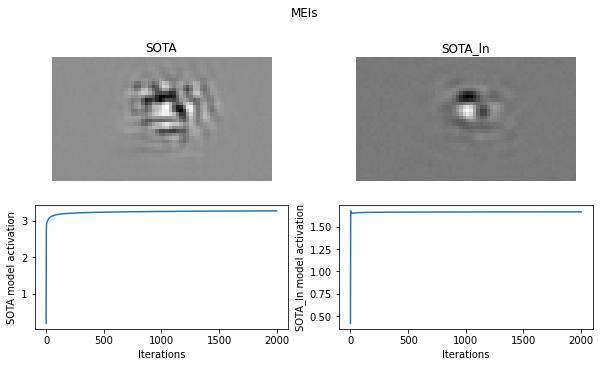

In [26]:
# compare the two meis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes[0,0].imshow(mei_sota_cnn, cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title('SOTA')
axes[1,0].plot(activation_sota_cnn)
axes[1,0].set_ylabel('SOTA cnn model activation')
axes[1,0].set_xlabel('Iterations')
axes[0,1].imshow(mei_sota_ln, cmap='gray')
axes[0,1].axis('off')
axes[0,1].set_title('SOTA_ln')
axes[1,1].plot(activation_sota_ln)
axes[1,1].set_ylabel('SOTA linear model activation')
axes[1,1].set_xlabel('Iterations')
plt.suptitle('MEIs', y=1.02)

### MEI cross activation

In [28]:
neuron_idx_ls = np.random.randint(0, high=5335, size=20)
meis = []
for i in tqdm(neuron_idx_ls):
    _, mei = generate_mei(
            sota_cnn_model,
            input_image=np.random.normal(input_mean, input_std / 10, (36, 64)),
            neuron_idx=i,
            iterations=2000,
            mean_constr=input_mean,
            std_constr=input_std / 10,
            disable_progress_bar=True,
    )
    meis.append(mei)


100%|██████████| 20/20 [04:25<00:00, 13.25s/it]


Text(0.5, 0, 'Neurons')

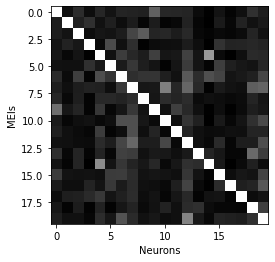

In [29]:
meis = torch.tensor(np.stack(meis))[:, None, ...].cuda()
activations = sota_cnn_model(meis).cpu().detach().numpy().squeeze()[:, neuron_idx_ls]
activations = activations / activations.max(axis=0, keepdims=True)
plt.imshow(activations, cmap='gray')
plt.ylabel('MEIs')
plt.xlabel('Neurons')